In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [122]:
!unzip -q /content/ACTUAL_PIA_preprocessed_data.zip -d .

In [1]:
PATH = './ACTUAL_PIA_preprocessed_data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.decomposition import PCA
import os
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

# Data preparation

In [3]:
def treat_data(data, desired_length=400):
    # Check if 'Qd' is in the DataFrame
    try:
        if 'Qd' in data:
            # Convert the pandas Series to a list
            data_list = data['Qd'].tolist()
            current_length = len(data_list)

            if current_length < desired_length:
                # Pad with zeros if shorter than desired length
                data_list.extend([0] * (desired_length - current_length))
            elif current_length > desired_length:
                # Truncate if longer than desired length
                data_list = data_list[:desired_length]

            return data_list
    except:
        pass

In [6]:
# FAIL
directory_path = f'{PATH}/FAIL'
V_fail = []
for filename in os.listdir(directory_path):
    # Construct the full file path
    file_path = os.path.join(directory_path, filename)

    # Check if the current file is a pickle file
    if filename.endswith('.pkl') or filename.endswith('.pickle'):
        print(f"Processing file: {filename}")

        # Load the pickle file
        with open(file_path, 'rb') as file:
            data = pkl.load(file)

        treated_data = treat_data(data)
        if treated_data is not None:
            V_fail.append(treated_data)

# NO FAIL
directory_path = f'{PATH}/NOT_FAIL'
V_notfail = []
for filename in os.listdir(directory_path):
    # Construct the full file path
    file_path = os.path.join(directory_path, filename)

    # Check if the current file is a pickle file
    if filename.endswith('.pkl') or filename.endswith('.pickle'):
        print(f"Processing file: {filename}")

        # Load the pickle file
        with open(file_path, 'rb') as file:
            data = pkl.load(file)

        treated_data = treat_data(data)
        if treated_data is not None:
            V_notfail.append(treated_data)

Processing file: b1c0.pkl_cycle_1666.pkl
Processing file: b1c0.pkl_cycle_1667.pkl
Processing file: b1c0.pkl_cycle_1668.pkl
Processing file: b1c0.pkl_cycle_1669.pkl
Processing file: b1c0.pkl_cycle_1670.pkl
Processing file: b1c0.pkl_cycle_1671.pkl
Processing file: b1c0.pkl_cycle_1672.pkl
Processing file: b1c0.pkl_cycle_1673.pkl
Processing file: b1c0.pkl_cycle_1674.pkl
Processing file: b1c0.pkl_cycle_1675.pkl
Processing file: b1c0.pkl_cycle_1676.pkl
Processing file: b1c0.pkl_cycle_1677.pkl
Processing file: b1c0.pkl_cycle_1678.pkl
Processing file: b1c0.pkl_cycle_1679.pkl
Processing file: b1c0.pkl_cycle_1680.pkl
Processing file: b1c0.pkl_cycle_1681.pkl
Processing file: b1c0.pkl_cycle_1682.pkl
Processing file: b1c0.pkl_cycle_1683.pkl
Processing file: b1c0.pkl_cycle_1684.pkl
Processing file: b1c0.pkl_cycle_1685.pkl
Processing file: b1c0.pkl_cycle_1686.pkl
Processing file: b1c0.pkl_cycle_1687.pkl
Processing file: b1c0.pkl_cycle_1688.pkl
Processing file: b1c0.pkl_cycle_1689.pkl
Processing file:

In [7]:
max_value = max(np.max(V_notfail), np.max(V_fail))
max_value

1.0974227

In [8]:
def prepareData(data):
    # Assume data_list_of_lists is your list of lists representing input data points
    data_list_of_lists = data

    # Convert data to NumPy array and normalize to [0, 1]
    data_array = np.array(data_list_of_lists)
    max_value = 1.0974227 # max(np.max(V_notfail), np.max(V_fail))
    data_array_normalized = data_array.astype(float) / max_value  # Normalize to [0, 1]

    # Convert NumPy array to PyTorch tensor
    data_tensor = torch.FloatTensor(data_array_normalized)
    return data_tensor

In [9]:
test_percent = int(len(V_fail)*0.1)
test_fail = V_fail[-test_percent:]
test_no_fail = V_notfail[-test_percent:]


V_Fail_tensor = prepareData(V_fail[:-test_percent])
V_Not_Fail_tensor = prepareData(V_notfail[:-test_percent])
concatenated_tensor = torch.concat([V_Fail_tensor, V_Not_Fail_tensor])

Test_V_Fail_tensor = prepareData(test_fail)
Test_V_Not_Fail_tensor = prepareData(test_no_fail)

# VAE

In [10]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_size, 256)
        self.encoder_fc2_mean = nn.Linear(256, latent_size)
        self.encoder_fc2_logvar = nn.Linear(256, latent_size)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_size, 256)
        self.decoder_fc2 = nn.Linear(256, input_size)

    def encode(self, x):
        x = F.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def decode(self, z):
        z = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(z))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Define the loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [23]:
print(input_size)

400


In [11]:
# Hyperparameters
input_size = len(concatenated_tensor[0])
latent_size = 5
learning_rate = 1e-2
num_epochs = 1000

# Initialize VAE model
VAEmodel = VAE(input_size, latent_size)

# Define optimizer
optimizer = optim.Adam(VAEmodel.parameters(), lr=learning_rate)

# Convert data to PyTorch tensor
data_tensor = torch.FloatTensor(concatenated_tensor)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon_batch, mu, logvar = VAEmodel(data_tensor)
    loss = vae_loss(recon_batch, data_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

c:\Users\pelot\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/1000], Loss: 2118297.5000
Epoch [2/1000], Loss: 2353434.2500
Epoch [3/1000], Loss: 1753131.8750
Epoch [4/1000], Loss: 2397602.0000
Epoch [5/1000], Loss: 1758256.0000
Epoch [6/1000], Loss: 1665102.2500
Epoch [7/1000], Loss: 1732424.1250
Epoch [8/1000], Loss: 1769453.8750
Epoch [9/1000], Loss: 1768587.5000
Epoch [10/1000], Loss: 1743017.0000
Epoch [11/1000], Loss: 1702679.8750
Epoch [12/1000], Loss: 1662642.2500
Epoch [13/1000], Loss: 1638980.6250
Epoch [14/1000], Loss: 1652044.0000
Epoch [15/1000], Loss: 1662453.5000
Epoch [16/1000], Loss: 1635112.2500
Epoch [17/1000], Loss: 1608026.0000
Epoch [18/1000], Loss: 1601523.2500
Epoch [19/1000], Loss: 1604932.2500
Epoch [20/1000], Loss: 1608431.3750
Epoch [21/1000], Loss: 1609938.7500
Epoch [22/1000], Loss: 1604315.1250
Epoch [23/1000], Loss: 1597077.5000
Epoch [24/1000], Loss: 1585910.6250
Epoch [25/1000], Loss: 1577828.8750
Epoch [26/1000], Loss: 1574523.6250
Epoch [27/1000], Loss: 1572472.0000
Epoch [28/1000], Loss: 1570032.0000
E

In [12]:
def getEmbeddings(data_tensor):
    with torch.no_grad():
        mean, logvar = VAEmodel.encode(data_tensor)
    embeddings = torch.cat((mean, logvar), dim=1)  # Concatenate mean and logvar along dimension 1
    embeddings = embeddings.numpy()  # Convert embeddings tensor to NumPy array
    return embeddings

In [13]:
V_Fail_embs = getEmbeddings(V_Fail_tensor)
V_Not_Fail_embs = getEmbeddings(V_Not_Fail_tensor)

Test_V_Fail_embs = getEmbeddings(Test_V_Fail_tensor)
Test_V_Not_Fail_embs = getEmbeddings(Test_V_Not_Fail_tensor)

In [14]:
# Convert embeddings to pandas DataFrames
T0_df = pd.DataFrame(V_Fail_embs)
T25_df = pd.DataFrame(V_Not_Fail_embs)

# Add a new column with the dataset name
T0_df['Dataset'] = 'Fail'
T25_df['Dataset'] = 'NOT'

# Concatenate the DataFrames into one
df = pd.concat([T0_df, T25_df], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)

# Print the combined DataFrame
print(df)

             0         1         2         3         4         5         6  \
965   0.015692  0.015089 -0.007119 -0.017760  0.623619  0.043411  0.036918   
7482  0.012657  0.013716 -0.011556 -0.020164  1.238419  0.062080  0.047328   
5148  0.001105  0.004603 -0.007829 -0.008722  1.235597  0.044894  0.026095   
6608  0.064311  0.066199 -0.014960 -0.070591 -0.133545  0.191118  0.158788   
2388 -0.074262 -0.072972  0.025968  0.080684  0.362657 -0.208102 -0.190314   
...        ...       ...       ...       ...       ...       ...       ...   
5191  0.012564  0.014793 -0.011046 -0.018840  1.176563  0.065369  0.048128   
5226 -0.037943 -0.033656  0.010754  0.038752  0.559079 -0.080512 -0.084137   
5390 -0.042813 -0.041336  0.013109  0.043999  0.551970 -0.110082 -0.104485   
860   0.005164 -0.001162  0.013184  0.009907 -0.651671 -0.060966 -0.041457   
7270  0.004816  0.008306 -0.006915 -0.008604  1.011947  0.045021  0.027857   

             7         8         9 Dataset  
965   0.027020  0.

In [15]:
# TEST
# Convert embeddings to pandas DataFrames
T0_df = pd.DataFrame(Test_V_Fail_embs)
T25_df = pd.DataFrame(Test_V_Not_Fail_embs)

# Add a new column with the dataset name
T0_df['Dataset'] = 'Fail'
T25_df['Dataset'] = 'NOT'

# Concatenate the DataFrames into one
test_df = pd.concat([T0_df, T25_df], ignore_index=True)

# Shuffle the DataFrame
test_df = test_df.sample(frac=1, random_state=42)

In [16]:
# Assuming df is your DataFrame containing the embeddings and dataset names

# Step 1: Prepare the data
X = df.drop(columns=['Dataset'])  # Input features (embeddings)
y = df['Dataset']                 # Target labels (dataset names)

# Step 2: Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Define the model
model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(126, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer with softmax activation for classification

# Step 4: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=25)

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy}")


Epoch 1/10
242/242 [==============================] - 4s 7ms/step - loss: 0.2186 - accuracy: 0.9280 - val_loss: 0.1956 - val_accuracy: 0.9390
Epoch 2/10
242/242 [==============================] - 1s 5ms/step - loss: 0.1940 - accuracy: 0.9330 - val_loss: 0.1738 - val_accuracy: 0.9482
Epoch 3/10
242/242 [==============================] - 1s 6ms/step - loss: 0.1794 - accuracy: 0.9374 - val_loss: 0.1632 - val_accuracy: 0.9456
Epoch 4/10
242/242 [==============================] - 1s 5ms/step - loss: 0.1738 - accuracy: 0.9399 - val_loss: 0.1610 - val_accuracy: 0.9502
Epoch 5/10
242/242 [==============================] - 1s 4ms/step - loss: 0.1680 - accuracy: 0.9408 - val_loss: 0.1539 - val_accuracy: 0.9496
Epoch 6/10
242/242 [==============================] - 1s 5ms/step - loss: 0.1704 - accuracy: 0.9398 - val_loss: 0.1585 - val_accuracy: 0.9502
Epoch 7/10
242/242 [==============================] - 1s 5ms/step - loss: 0.1642 - accuracy: 0.9427 - val_loss: 0.1447 - val_accuracy: 0.9496
Epoch 

In [17]:
# Evaluate the model
X_test = test_df.drop(columns=['Dataset'])  # Input features (embeddings)
y_test = label_encoder.fit_transform(test_df['Dataset'])
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

26/26 [==============================] - 0s 2ms/step - loss: 5.8782 - accuracy: 0.4976
Test Accuracy: 0.4975961446762085


26/26 [==============================] - 0s 4ms/step


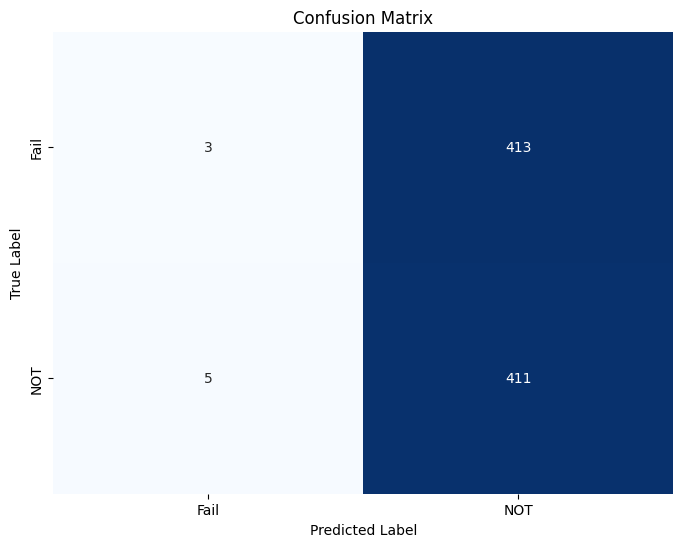

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming model is your trained Keras model and X_val, y_val are your validation data

# Step 1: Use the trained model to make predictions on the validation data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Step 2: Convert predicted labels back to their original class names
label_encoder = LabelEncoder()
label_encoder.fit(y)  # Fit the label encoder on the original class names
y_pred_names = label_encoder.inverse_transform(y_pred_labels)  # Convert encoded labels back to class names

# Step 3: Compute the confusion matrix
conf_matrix = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_names)

# Create a DataFrame for the confusion matrix
class_names = label_encoder.classes_
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


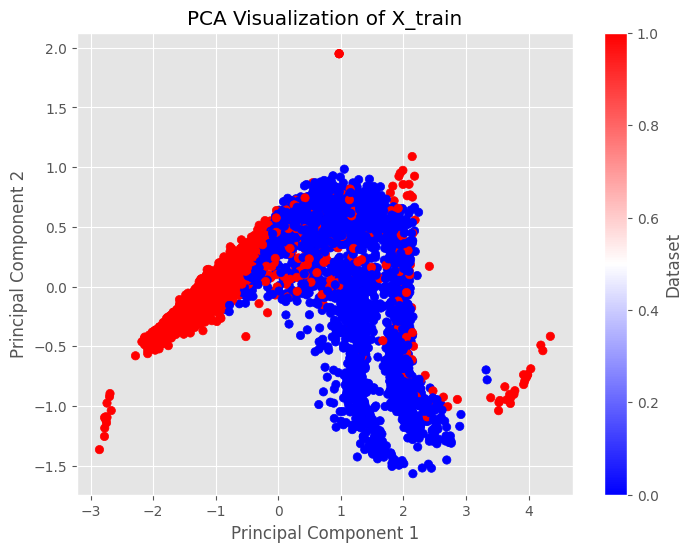

In [19]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_train)

plt.style.use('ggplot')

# Visualize the data points
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='bwr')
plt.title('PCA Visualization of X_train')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Dataset')
plt.show()


In [20]:
class Model():
    def __init__(self, VAEmodel, Classifier, label_encoder, input_dim=400):
        self.VAEmodel = VAEmodel
        self.Classifier = Classifier
        self.input_dim = input_dim
        self.label_encoder = label_encoder

    # Auxiliary functions
    def treat_data(data, desired_length=400):
        # Check if 'Qd' is in the DataFrame
        if 'Qd' in data:
            # Convert the pandas Series to a list
            data_list = data['Qd'].tolist()
            current_length = len(data_list)

            if current_length < desired_length:
                # Pad with zeros if shorter than desired length
                data_list.extend([0] * (desired_length - current_length))
            elif current_length > desired_length:
                # Truncate if longer than desired length
                data_list = data_list[:desired_length]

        return data_list

    def prepareData(data):

        # Assume data_list_of_lists is your list of lists representing input data points
        data_list_of_lists = data

        # Convert data to NumPy array and normalize to [0, 1]
        data_array = np.array(data_list_of_lists)
        max_value = max(np.max(V_notfail), np.max(V_fail))
        data_array_normalized = data_array.astype(float) / max_value  # Normalize to [0, 1]

        # Convert NumPy array to PyTorch tensor
        data_tensor = torch.FloatTensor(data_array_normalized)
        return data_tensor

    def getEmbeddings(self, data_tensor):
        with torch.no_grad():
            mean, logvar = self.VAEmodel.encode(data_tensor)
        embeddings = torch.cat((mean, logvar), dim=1)  # Concatenate mean and logvar along dimension 1
        embeddings = embeddings.numpy()  # Convert embeddings tensor to NumPy array
        return embeddings

    def format_input(self, data_or_path):
        if isinstance(data_or_path, str):
            input_data = pd.read_csv(data_or_path)
        else:
            input_data = data_or_path
        treated_data = np.array([treat_data(input_data, self.input_dim)])
        data_tensor = prepareData(treated_data)
        data_embeddings = getEmbeddings(data_tensor)
        return pd.DataFrame(data_embeddings)

    # Methods
    def predict(self, data_or_path):
        formatted_data = self.format_input(data_or_path)
        class_probabilities = self.Classifier.predict(formatted_data)
        prediction = np.argmax(class_probabilities, axis=1)
        return self.label_encoder.inverse_transform(prediction)[0]

    def predict_multiple(self, path_to_data):
        df = pd.read_csv(path_to_data)
        battery_ids = df['Battery_ID'].unique()
        # List to store separated DataFrames
        separated_dfs = []
        # Iterate over unique battery IDs
        for battery_id in battery_ids:
            # Filter the DataFrame for the current battery ID
            filtered_df = df[df['Battery_ID'] == battery_id]
            # Append the filtered DataFrame to the list
            separated_dfs.append(filtered_df)
        # Generate the prediction for each
        predictions = []
        for battery_data in separated_dfs:
            prediction = self.predict(battery_data)
            predictions.append(prediction)
            print(prediction)
        return predictions

In [21]:
modelo_final = Model(VAEmodel, model, label_encoder)

In [22]:
# Save the model to a pickle file
torch.save(VAEmodel.state_dict(), 'MODELO_VAE.pth')

model.save('MODELO_NN.h5')

with open('LABEL_ENCODER.pkl', 'wb') as f:
    pkl.dump(label_encoder, f)